In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis
import time
import scipy.stats
import copy
import statsmodels
from statsmodels.stats.anova import AnovaRM

root = '/usr/local/serenceslab/maggie/shapeDim/'
sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils, plot_utils, stats_utils, grid_utils

In [12]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 12)
figfolder = os.path.join(root, 'Analysis','figures')

In [13]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 10
subjects = np.arange(1,11)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [14]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
    

In [21]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_binary_withintask_matchnumvoxels.npy')
print(save_filename)
print(time.ctime(os.path.getmtime(save_filename)))
dec = np.load(save_filename, allow_pickle=True).item()
dec.keys()
roi_names = dec['roi_names']
n_rois = len(roi_names)

/usr/local/serenceslab/maggie/shapeDim/Analysis/decoding_results/decode_binary_withintask_matchnumvoxels.npy
Mon Feb 24 22:53:41 2025


In [6]:
# save_folder = os.path.join(root, 'Analysis', 'decoding_results')
# save_filename = os.path.join(save_folder, 'decode_binary_withintask_matchnumvoxels2.npy')
# print(save_filename)
# print(time.ctime(os.path.getmtime(save_filename)))
# dec2 = np.load(save_filename, allow_pickle=True).item()
# dec2.keys()
# roi_names = dec2['roi_names']
# n_rois = len(roi_names)

In [7]:
# save_folder = os.path.join(root, 'Analysis', 'decoding_results')
# save_filename = os.path.join(save_folder, 'decode_binary_withintask.npy')
# print(save_filename)
# print(time.ctime(os.path.getmtime(save_filename)))
# dec_orig = np.load(save_filename, allow_pickle=True).item()


In [8]:
# save_folder = os.path.join(root, 'Analysis', 'decoding_results')
# save_filename = os.path.join(save_folder, 'decode_binary_withintask_matchnumvoxels1.npy')
# print(save_filename)
# print(time.ctime(os.path.getmtime(save_filename)))
# dec1 = np.load(save_filename, allow_pickle=True).item()
# dec1.keys()
# roi_names = dec['roi_names']
# n_rois = len(roi_names)

In [9]:
# np.max(np.abs(dec['acc_bytask']-dec1['acc_bytask']))

In [6]:
dec['acc_bytask'].shape

(10, 8, 4, 3)

#### accuracy along each linear axis, in each task

In [6]:
n_tasks = 4

acc_fartrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

acc_midtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3,4]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        is_main_grid = l['is_main_grid']==1
        
        for ii in [0,1]:

            # actual category along this axis
            categ_actual = np.array(l['categ_task%d'%(ii+1)])
    
            dist_from_center = np.array(l['dist_from_bound%d'%(ii+1)]).round(1)
            
            # separate near (i.e. middle) and far trials
            # these are all in main grid, different distances from boundary.
            is_far = (dist_from_center==2.4) & is_main_grid
            is_middle = (dist_from_center==0.8) & is_main_grid
           
            is_correct = np.array(l['subject_correct'])
            
            for ri in range(n_rois):

                # switching categs here so that 1=coord<center, 2=coord>center
                categ_pred = 3-dec['preds_all'][si][ri][ti][ii].astype(int)
             
                # easy trials
                inds = is_far & is_correct
                
                acc_fartrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                # medium trials
                inds = is_middle & is_correct
                
                acc_midtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                

In [7]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
figfolder = os.path.join(root, 'Analysis','figures')

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/binary_acc_Far_matchnumvoxels.pdf
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/binary_acc_Near_matchnumvoxels.pdf


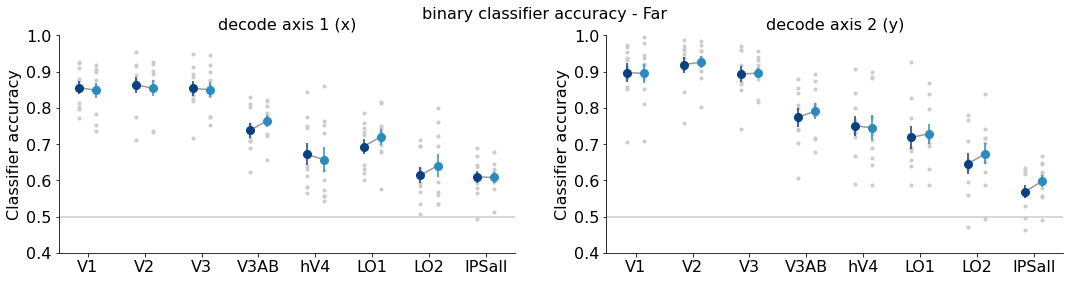

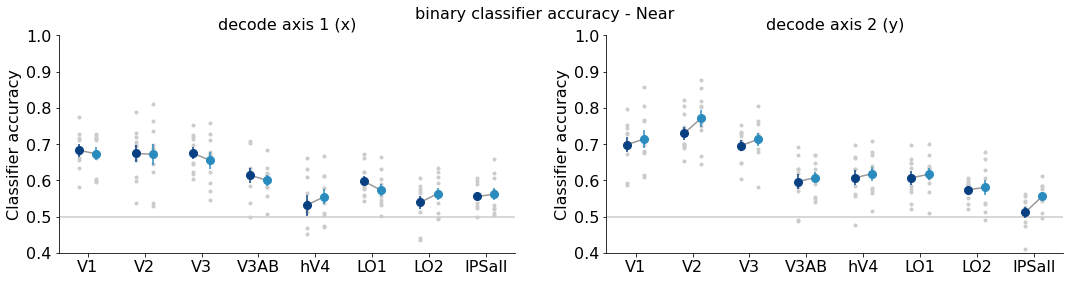

In [8]:
ti_plot = [0,1]

x_jitter = np.linspace(-0.15, 0.15, 2)

    
for avals, name in zip([acc_fartrials, acc_midtrials], \
                     ['Far','Near']):
    
    plt.figure(figsize=(18,4))
    
    # rvals = rvals[0:7]

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        ax = plt.subplot(1,2,ii+1)

        plt.axhline(1/2, color=[0.8, 0.8, 0.8])

        lh = []

        for ti in ti_plot:

            x_ticks = np.arange(n_rois) + x_jitter[ti]

            vals = avals[:,:,ti,ii]
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti], markersize=8, zorder=10)
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], \
                             linestyle='none', zorder=10)
            lh.append(h)
            
        for ri in range(n_rois):
            
            meanvals = np.mean(avals[:,ri,ti_plot,ii], axis=0)
            plt.plot([ri+x_jitter[0], ri+x_jitter[1]], meanvals,'-',color=[0.6, 0.6, 0.6])

            plt.plot(ri+x_jitter, avals[:,ri,ti_plot,ii].T, '.', color=[0.8, 0.8, 0.8], zorder=-10)
            
        plt.ylim([0.4, 1.0])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('Classifier accuracy')

        # plt.legend(lh,np.array(task_names)[ti_plot])

        plt.title('decode %s'%axis_name)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.suptitle('binary classifier accuracy - %s'%name)
    
    figname = os.path.join(figfolder, 'binary_acc_%s_matchnumvoxels.pdf'%(name))
    print(figname)
    plt.savefig(figname)
# 


In [9]:
source_data_folder = os.path.join(root, 'Analysis','source_data_nc','SuppFigure01')
if not os.path.exists(source_data_folder):
    os.makedirs(source_data_folder)

from code_utils import numpy_utils

for avals, name, letter in zip([acc_fartrials, acc_midtrials], \
                     ['Far','Near'], ['A','B']):
    
    a = avals[:,:,0:2,:]
    dim_labels = ['Subject','ROI','Task','Classifier Type']
    print(a.shape)
    
    # make it a single df array for CSV exporting.
    source_df = numpy_utils.array_to_dataframe(a, dim_labels)
    print(source_df.shape)
    
    data_name = os.path.join(source_data_folder, 'SuppFigure01%s_%s.csv'%(letter, name))
    
    print(data_name)
    source_df.to_csv(data_name)
    

(10, 8, 2, 2)
(320, 5)
/usr/local/serenceslab/maggie/shapeDim/Analysis/source_data_nc/SuppFigure01/SuppFigure01A_Far.csv
(10, 8, 2, 2)
(320, 5)
/usr/local/serenceslab/maggie/shapeDim/Analysis/source_data_nc/SuppFigure01/SuppFigure01B_Near.csv


In [10]:
source_df

,Subject,ROI,Task,Classifier Type,value
0,0,0,0,0,0.634615
1,0,0,0,1,0.586207
2,0,0,1,0,0.670391
3,0,0,1,1,0.613497
4,0,1,0,0,0.538462
...,...,...,...,...,...
315,9,6,1,1,0.577640
316,9,7,0,0,0.551948
317,9,7,0,1,0.503030
318,9,7,1,0,0.524096


In [9]:

for xx, [avals, diffname] in enumerate(zip([acc_fartrials, acc_midtrials], \
                        ['Far','Near'])):

    
    vals = copy.deepcopy(avals[:,:,0:2,0:2])

    anova_result = stats_utils.rmanova_3way(vals, ['ROI','Task','Boundary'], \
                                            # do_shuffle=False)
                                           do_shuffle=True, n_iter=10000, rndseed = 423443+xx)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    tablename = os.path.join(figfolder, 'decodebinary_binary_acc_lin1vs2_rm_anova_%s_matchnumvoxels.csv'%(diffname))
    
    print(tablename)
    anova_result.to_csv(tablename)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_lin1vs2_rm_anova_Far_matchnumvoxels.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_lin1vs2_rm_anova_Near_matchnumvoxels.csv


In [10]:
for diffname in ['Far','Near']:
    
    tablename = os.path.join(figfolder, 'decodebinary_binary_acc_lin1vs2_rm_anova_%s_matchnumvoxels.csv'%(diffname))
    print(tablename)
    print(time.ctime(os.path.getmtime(tablename)))
    anova_result = pd.read_csv(tablename, index_col=0)
    print('\nAnova for accuracy, %s trials'%(diffname))
    
    print(anova_result)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_lin1vs2_rm_anova_Far_matchnumvoxels.csv
Wed Feb 26 14:07:36 2025

Anova for accuracy, Far trials
                     F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI                78.268514     7.0    63.0  0.0000           0.0000
Task                1.383047     1.0     9.0  0.2698           0.2664
Boundary           63.789914     1.0     9.0  0.0000           0.0000
ROI:Task            1.542475     7.0    63.0  0.1695           0.1660
ROI:Boundary        4.208765     7.0    63.0  0.0007           0.0000
Task:Boundary       0.325785     1.0     9.0  0.5821           0.5827
ROI:Task:Boundary   0.372626     7.0    63.0  0.9149           0.9169
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_lin1vs2_rm_anova_Near_matchnumvoxels.csv
Wed Feb 26 14:22:20 2025

Anova for accuracy, Near trials
                     F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI           

In [11]:
for avals, diffname in zip([acc_fartrials, acc_midtrials], \
                        ['Far','Near']):

    for ii, axis_name in enumerate(['axis1','axis2']):

        vals = copy.deepcopy(avals[:,:,0:2,ii])

        anova_result = stats_utils.rmanova_2way(vals, ['ROI','Task'], \
                                                # do_shuffle=False)
                                                do_shuffle=True, n_iter=10000, rndseed = 243434+ii)

        
        anova_result['Pr > F'] = anova_result['Pr > F'].round(4)
    
        tablename = os.path.join(figfolder, 'decodebinary_binary_acc_rm_anova_%s_%s_matchnumvoxels.csv'%(axis_name, diffname))
    
        print(tablename)
        anova_result.to_csv(tablename)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_rm_anova_axis1_Far_matchnumvoxels.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_rm_anova_axis2_Far_matchnumvoxels.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_rm_anova_axis1_Near_matchnumvoxels.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_rm_anova_axis2_Near_matchnumvoxels.csv


In [12]:
for diffname in ['Far','Near']:
    for axis_name in ['axis1','axis2']:

        tablename = os.path.join(figfolder, 'decodebinary_binary_acc_rm_anova_%s_%s_matchnumvoxels.csv'%(axis_name, diffname))
        print(tablename)
        print(time.ctime(os.path.getmtime(tablename)))
        anova_result = pd.read_csv(tablename, index_col=0)
        print('\nAnova for %s accuracy, %s trials'%(axis_name, diffname))
        print(anova_result)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_rm_anova_axis1_Far_matchnumvoxels.csv
Wed Feb 26 14:26:17 2025

Anova for axis1 accuracy, Far trials
            F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI       55.250720     7.0    63.0  0.0000           0.0000
Task       0.420369     1.0     9.0  0.5329           0.5337
ROI:Task   1.403141     7.0    63.0  0.2199           0.2193
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_rm_anova_axis2_Far_matchnumvoxels.csv
Wed Feb 26 14:30:14 2025

Anova for axis2 accuracy, Far trials
            F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI       59.656936     7.0    63.0  0.0000           0.0000
Task       1.629309     1.0     9.0  0.2338           0.2304
ROI:Task   0.529076     7.0    63.0  0.8093           0.8014
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_rm_anova_axis1_Near_matchnumvoxels.csv
Wed Feb 26 14:34:11 2025

Anova

In [13]:
for avals, diffname in zip([ acc_midtrials], \
                        ['Near']):

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        vals = copy.deepcopy(avals[:,:,0:2,ii])
        
        tstats_task = np.zeros((n_rois,),dtype=float)
        pvals_task = np.zeros((n_rois,),dtype=float)
        n_subs_samedir = np.zeros((n_rois,),dtype=int)

        rndseed = 8676786
        for rr in range(n_rois):

            t1_values = vals[:,rr,0]
            t2_values = vals[:,rr,1]
            p, t = stats_utils.paired_ttest_nonpar(t1_values, t2_values, \
                                                   # n_iter=2,
                                                   n_iter=10000, \
                                                   rndseed=rndseed+rr)    
            tstats_task[rr] = t
            pvals_task[rr] = p

            subj_diffs = t1_values - t2_values
            n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

        print('\n%s trials, %s'%(diffname, axis_name))
        task_df = pd.DataFrame({'t-stat for task 1 > task 2': tstats_task, \
                                'pvalue': pvals_task, \
                                'n_subs_indiv': n_subs_samedir}, \
                                  index=roi_names)
        print(task_df.round(3))


Near trials, axis 1 (x)
        t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                           0.556   0.592             5
V2                           0.094   0.927             5
V3                           1.599   0.144             6
V3AB                         0.639   0.544             6
hV4                         -0.878   0.478             6
LO1                          2.336   0.038             8
LO2                         -1.472   0.179             7
IPSall                      -0.294   0.774             5

Near trials, axis 2 (y)
        t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                          -1.038   0.336             7
V2                          -2.580   0.036             8
V3                          -1.284   0.231             6
V3AB                        -0.482   0.639             5
hV4                         -0.576   0.592             7
LO1                         -0.551   0.669             6
LO2                         -0.360   0

#### Verify that this gave same result as original, for the smallest ROI

In [41]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_binary_withintask.npy')
print(save_filename)
print(time.ctime(os.path.getmtime(save_filename)))
dec_orig = np.load(save_filename, allow_pickle=True).item()
dec_orig.keys()
roi_names = dec_orig['roi_names']
n_rois = len(roi_names)

/usr/local/serenceslab/maggie/shapeDim/Analysis/decoding_results/decode_binary_withintask.npy
Wed Aug 14 23:11:22 2024


In [42]:
roi_names

['V1', 'V2', 'V3', 'V3AB', 'hV4', 'LO1', 'LO2', 'IPSall']

In [43]:
dec_orig['acc_bytask'].shape

(10, 8, 4, 3)

In [44]:
si = 0;
ri = 6;

dec_orig['acc_bytask'][si,ri,:,:] == dec['acc_bytask'][si,ri,:,:]

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [45]:
a = np.zeros([10,8])

for si in range(10):
    for ri in range(8):
        # print(roi_names[ri])

        a[si,ri] = np.all(dec_orig['acc_bytask'][si,ri,:,:] == dec['acc_bytask'][si,ri,:,:])

In [46]:
a

array([[0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.]])

In [48]:
si = 6
for ri in range(8):
    print(roi_names[ri])

    print(dec_orig['acc_bytask'][si,ri,:,:] == dec['acc_bytask'][si,ri,:,:])

V1
[[False False  True]
 [False False False]
 [False False False]
 [False False False]]
V2
[[False False False]
 [False False False]
 [False False False]
 [False False False]]
V3
[[False False False]
 [False False False]
 [False False False]
 [False False False]]
V3AB
[[False False False]
 [False False False]
 [False False False]
 [False False False]]
hV4
[[False False False]
 [False  True False]
 [False  True False]
 [False  True False]]
LO1
[[False False False]
 [False False False]
 [False False False]
 [False False False]]
LO2
[[ True  True  True]
 [ True  True False]
 [ True  True  True]
 [ True  True  True]]
IPSall
[[False False False]
 [False False False]
 [False False False]
 [False False False]]


In [49]:
ri = 6;
print(roi_names[ri])
print(dec_orig['acc_bytask'][si,ri,:,:] == dec['acc_bytask'][si,ri,:,:])

LO2
[[ True  True  True]
 [ True  True False]
 [ True  True  True]
 [ True  True  True]]


In [50]:
dec_orig['acc_bytask'][si,ri,:,:], dec['acc_bytask'][si,ri,:,:]

(array([[0.4921875 , 0.5234375 , 0.55208333],
        [0.52864583, 0.59375   , 0.59375   ],
        [0.51041667, 0.57552083, 0.5234375 ],
        [0.51339286, 0.60267857, 0.52232143]]),
 array([[0.4921875 , 0.5234375 , 0.55208333],
        [0.52864583, 0.59375   , 0.59635417],
        [0.51041667, 0.57552083, 0.5234375 ],
        [0.51339286, 0.60267857, 0.52232143]]))